So now that I've decided that I'm going to use 1-min RV as my volatility proxy, I can move on to the juicy part: forecasting.

# The Data

---


In [1]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from scipy import stats

# Set default figure size
plt.rcParams["figure.figsize"] = (15, 10)
pd.plotting.register_matplotlib_converters()

In [2]:
# Here's my minute data for the S&P 500
spx_minute = pd.read_csv("SPX_1min.csv", header=0,names=['datetime', 'open', 'high', 'low', 'close'],
                                  index_col='datetime', parse_dates=True)

In [3]:
# Here's the function for calculating the 1-min RV, as discussed in my last post
def rv_calc(data):
    results = {}
    
    for idx, data in data.groupby(data.index.date):
        returns = np.log(data['close']) - np.log(data['close'].shift(1))
        results[idx] = np.sum(returns**2)
        
    return pd.Series(results)

In [4]:
spx_rv = rv_calc(spx_minute)

# The Model

My goal is to predict the volatility over the next week, or 5 trading days, with the past 5 days of daily volatility. This means my independent variables will be the last 5 days of volatility, and my dependent variable is the realized volatility over the next 5 days. For the sake of increased samples, I'm going to create a rolling 5-day window of volatility and shift it 5 periods backwards and use that as the dependent variable. This means I can create a 5-day volatility forecast for each day, rather than each week.

In [1]:
def create_lags(series, lags):
    """
    Creates a dataframe with lagged values of the given series.
    Generates columns named x_{n} which means the value of each row is the value of the original series lagged n times
    """
    result = pd.DataFrame(index=series.index)
    result["x"] = series
    
    for n in range(lags):
        result[f"x_{n+1}"] = series.shift((n+1))
        
    return result

In [6]:
dep_var = spx_rv.rolling(5).sum().shift(-5).dropna()
indep_var = create_lags(spx_rv, 5).dropna()
# This ensures that we only keep rows that occur in each set. This means their length is the same and
# rows match up properly
common_index = dep_var.index.intersection(indep_var.index)
dep_var = dep_var.loc[common_index]
indep_var = indep_var.loc[common_index]

In [7]:
# I'm going to take the log of the variance because it has better distributional qualities
dep_var = np.log(dep_var)
indep_var = np.log(indep_var)

I'm going to use a very simple Bayesian linear regression for this model. It assumes the data is distributed according to

$y \sim normal(\mu + X\beta, \sigma)$

where $\mu$ is a constant, $X$ are the independent variables, $\beta$ are the regression coeffcicents, and $\sigma$ is the noise term.

In [8]:
import pystan as stan
import arviz

In [9]:
model_spec = '''
data {
    int len;
    int vars;
    vector[len] dep_var;
    matrix[len, vars] indep_var;
}
parameters {
    real mu;
    vector[vars] beta;
    real<lower=0> sigma;
}
model {
    mu ~ cauchy(0, 10);
    beta ~ cauchy(0, 10);
    sigma ~ cauchy(0, 5);
    
    dep_var ~ normal(mu + (indep_var * beta), sigma);
}
'''

In [10]:
model = stan.StanModel(model_code=model_spec)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_842ef31b1beae12ccaeb1a8773757520 NOW.


# Model Testing and Verification

Okay, let's do some out of sample testing to see how our model does! Below, I'm defining the training and testing sets. I'm going to use 75% of the data for in-sample fitting and the remaining 25% for out-of-sample testing.

In [11]:
test_index = int(len(indep_var) * .75)
train_x = indep_var.iloc[:test_index]
train_y = dep_var[:test_index]
test_x = indep_var.iloc[test_index:]
test_y = dep_var[test_index:]

Now, I fit the model to the data.

In [12]:
params = {'len': len(train_x), 'vars': len(train_x.columns), 'dep_var': train_y, 'indep_var': train_x}

sample = model.sampling(data=params, chains=4, warmup=250, iter=1500)

Let's check our sampling statistics to ensure the sampler converged. R-hats all look very good and our effective samples also look good.

In [13]:
print(sample.stansummary(pars=['mu', 'beta', 'sigma']))

Inference for Stan model: anon_model_842ef31b1beae12ccaeb1a8773757520.
4 chains, each with iter=1500; warmup=250; thin=1; 
post-warmup draws per chain=1250, total post-warmup draws=5000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu        0.59  1.2e-3   0.09   0.42   0.53   0.59   0.65   0.77   5682    1.0
beta[1]   0.46  3.4e-4   0.02   0.42   0.45   0.46   0.47    0.5   3219    1.0
beta[2]   0.14  4.5e-4   0.02    0.1   0.13   0.14   0.16   0.18   2408    1.0
beta[3]   0.09  3.9e-4   0.02   0.04   0.07   0.09    0.1   0.13   3317    1.0
beta[4]   0.08  3.7e-4   0.02   0.03   0.06   0.08   0.09   0.12   3753    1.0
beta[5]   0.06  4.1e-4   0.02   0.01   0.04   0.06   0.07    0.1   2966    1.0
beta[6]   0.07  3.0e-4   0.02   0.03   0.06   0.07   0.08   0.11   4026    1.0
sigma     0.49  9.5e-5 6.9e-3   0.48   0.49   0.49    0.5   0.51   5295    1.0

Samples were drawn using NUTS at Wed Mar 17 19:28:01 2021.
For each parameter, n_eff is a crude meas

In [14]:
arviz_data = arviz.from_pystan(
    posterior=sample
)

We can look at trace plots for our samples. Good samples should look like fuzzy caterpillars, which is what we see here. The distributions also match across sampling chains. The variables also match our intuition: $\mu$ and $\beta$ are positive, and the regression coefficients are all positive.

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

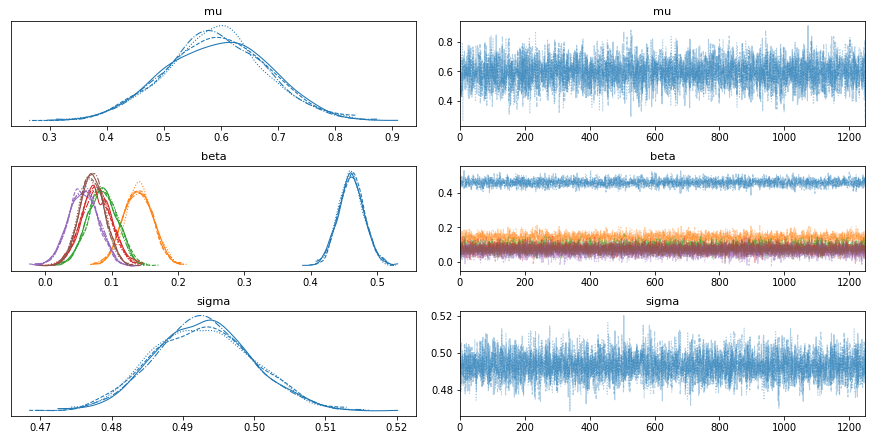

In [15]:
arviz.plot_trace(arviz_data, var_names=['mu', 'beta', 'sigma'])

The code below creates the posterior predictive distribution for the in-sample and out-of-sample data. These represent what the model predicts the distribution of the data is. The job now is to compare this predicted distribution to the reality.

In [16]:
mu = sample['mu']
beta = sample['beta']
sigma = sample['sigma']

In [17]:
# This is some tensordot sorcery that works, but that I don't frankly understand. It takes the matrix product of train_x
# and beta over each row of beta. Essentially a higher-dimensional version of what the model does.
train_post = np.random.normal(mu + (np.tensordot(train_x, beta, axes=(1,1))), sigma)
test_post = np.random.normal(mu + (np.tensordot(test_x, beta, axes=(1,1))), sigma)

train_post_mean = np.mean(train_post, axis=1)
test_post_mean = np.mean(test_post, axis=1)

Let's take a look at the in-sample and out-of-sample residuals. In this case, I'm making a point estimate by taking the mean of the posterior predictive distribution. It's obvious that the model has problems predicting volatility jumps, signified by unexpected jumps in the residuals.

Text(0.5, 1.0, 'In-Sample Residuals')

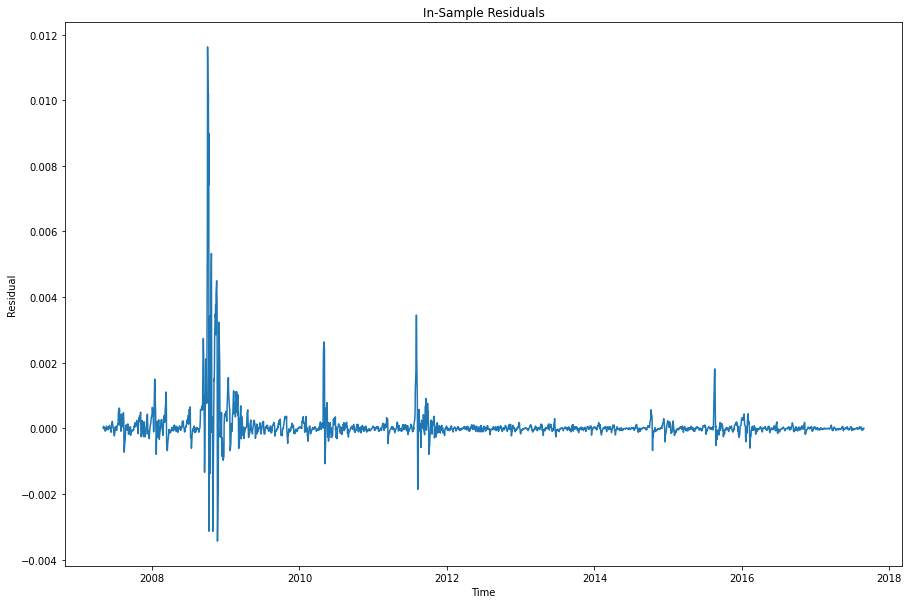

In [18]:
plt.plot(np.exp(train_y) - np.exp(train_post_mean))
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('In-Sample Residuals')

Text(0.5, 1.0, 'Out-of-Sample Residuals')

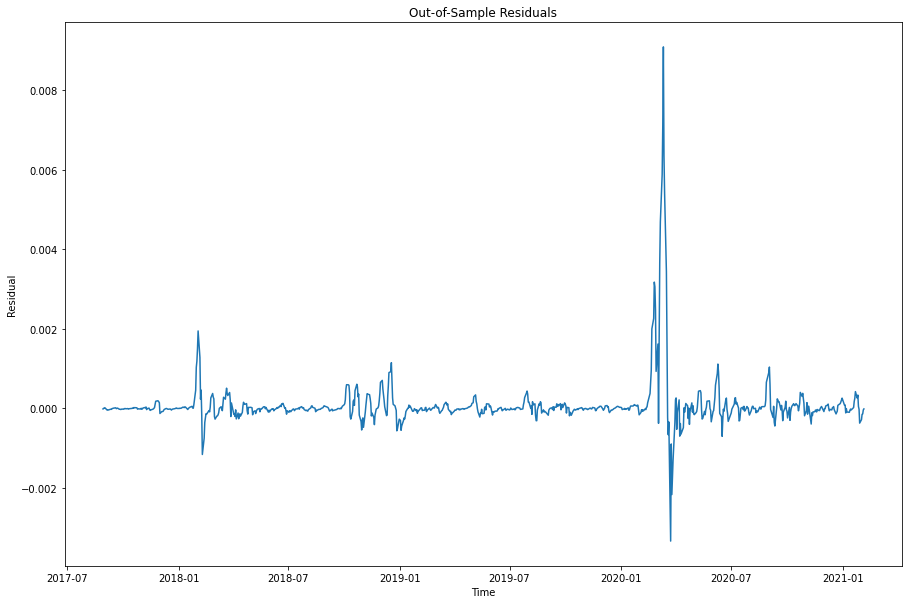

In [19]:
plt.plot(np.exp(test_y) - np.exp(test_post_mean))
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Out-of-Sample Residuals')

Now, let's look at the root mean square error of our model. Looks like our out-of-sample RMSE, using exponentiated values, is around 7% higher, not bad!

In [20]:
train_rmse = np.sqrt(np.mean((np.exp(train_y) - np.exp(train_post_mean))**2))
test_rmse = np.sqrt(np.mean((np.exp(test_y) - np.exp(test_post_mean))**2))
print(f'In-Sample RMSE: {train_rmse}\nOut-of-Sample RMSE: {test_rmse}')
print(f'Percent Increase: {(test_rmse / train_rmse) - 1}')

In-Sample RMSE: 0.0006314456099670146
Out-of-Sample RMSE: 0.0006745751839390536
Percent Increase: 0.06830291206600037


I like to do a Mincer-Zarnowitz regression to analyze out-of-sample forests. In this case, the out-of-sample predictions are treated as the independent variable and the true values are the dependent variable. The R-Squared for out model is about 64%, which means our out-of-sample predictions explain 64% of the variance of the true values. Not bad! The intercept is also very close to zero, which means our prediction isn't biased.

In [21]:
regress = stats.linregress(np.exp(test_post_mean), np.exp(test_y))
print(f'Intercept: {regress.intercept} \nSlope: {regress.slope} \nR-Squared: {regress.rvalue**2}')

Intercept: 1.7250208362578126e-05 
Slope: 1.183989352654772 
R-Squared: 0.6438180914963003


Next, I want to check the distributional assumptions. Specifically, I want to know how many times real volatility exceeds what our distribution predicts. To do this, I'm going to look at the posterior predictive distribution, which should, if our model is correct, accurately predict the distribution of the real data. I'll figure out the 95th percentile of the posterior predictive, and see how many times real volatility exceeded that. We should expect exceedances to happen about 5% of the time.

In [22]:
upper_bound_train = np.percentile(np.exp(train_post), 95, axis=1)
num_exceeds_train = (np.exp(train_y) > upper_bound_train).sum()

upper_bound_test = np.percentile(np.exp(test_post), 95, axis=1)
num_exceeds_test = (np.exp(test_y) > upper_bound_test).sum()

In [23]:
print(f'In-Sample Exceedances: {num_exceeds_train / len(upper_bound_train)}')
print(f'Out-of-Sample Exceedances: {num_exceeds_test / len(upper_bound_test)}')

In-Sample Exceedances: 0.0481139337952271
Out-of-Sample Exceedances: 0.09815242494226328


In-sample we are within 5%, and out-of-sample we are above 5% by about double, which isn't a good sign. Next up is testing the empirical distribution of the data. If our posterior predictive distribution is a good representation of the underlying distribution, doing a probability integral transform should transform the data into a uniform distribution.

In [24]:
class ECDF:
    def __init__(self, data):
        self.sorted = data
        self.sorted.sort()
        self.y = np.arange(1, len(self.sorted) + 1) / len(self.sorted)
        
    def __call__(self, x):
        ind = np.searchsorted(self.sorted, x) - 1
        return self.y[ind]

In [38]:
values = []

for x in range(len(test_post)):
    ecdf = ECDF(np.exp(test_post[x]))
    values.append(ecdf(np.exp(test_y[x])))

Text(0.5, 1.0, 'Transformed Data')

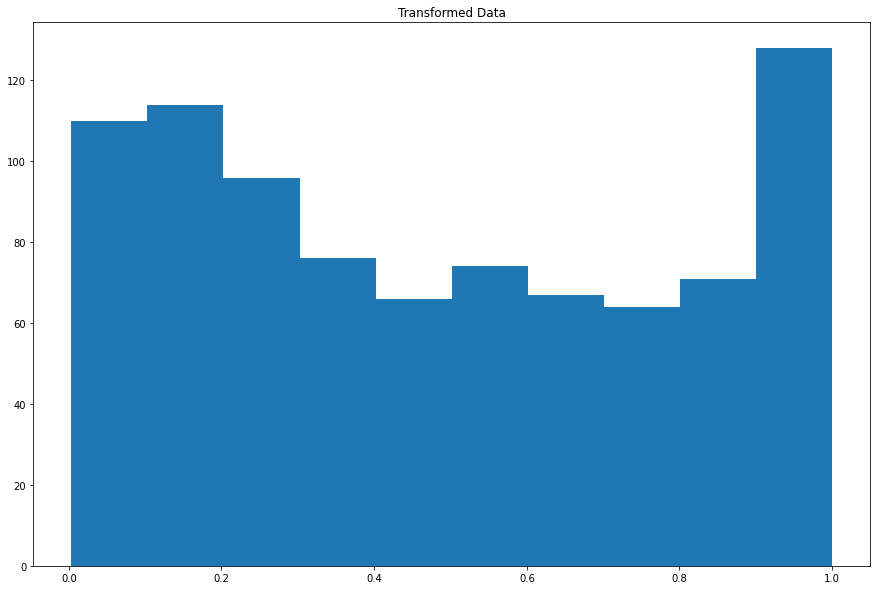

In [41]:
plt.hist(values)
plt.title('Transformed Data')

We can see an obvious deviation from the expected uniform distribution here. It looks like our distribution most significantly under-predicts large volatiltiy values. This makes sense when looking back to the residual graph, large jumps aren't handled well.

In [40]:
stats.kstest(values, 'uniform')

KstestResult(statistic=0.0760443418013857, pvalue=8.408548699568476e-05)

This Kolmogorov-Smirnov test takes the null hypothesis that the data matches the specified distribution, in this case a uniform. It looks like we can handedly reject that hypothesis. This means that the posterior predictive is not fully capable of representing the real distribution.

# Conclusion and Extensions

It seems like this very simple model does pretty well providing a point-forecast of future volatility, however it fails at accurately describing the distribution of future volatility. This could be fixed in several ways. First is assuming a different distributional form in the model, such as something with fatter tails like a Student's T. Another possibility is allowing the standard deviation of the normal to vary with time. That is more in line with models like traditional stochastic volatility.